# Kaggle Competition: Ames Housing Dataset
# Notebook 1: Danielle Reycer
## Cleaning and Modeling Data

- [Imports and Reading in DataSets](#Imports-and-Reading-in-DataSets) 
- [Cleaning and EDA](#Cleaning-and-EDA) 
- [Considering US Recession](#Considering-US-Recession)
- [Accounting for Neighborhood](#Accounting-for-Neighborhood)
- [Attempting Polynomial Features](#Attempting-Polynomial-Features)
- [Features Iterations](#Features-Iterations-(First-Attempts))
- [KFold Cross Validation](#KFold-Cross-Validation)
- [Exporting DataSets](#Exporting-DataSets)


### Imports and Reading in DataSets

In [2]:
import numpy as np
import pandas as pd
import scipy as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import (cross_val_score, 
                                     train_test_split, 
                                     cross_validate, 
                                     KFold)

In [3]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [4]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


### Cleaning and EDA

In [6]:
# changing column names to be lowercase and snake case

train.columns = train.columns.str.replace(' ','_')
train.columns = train.columns.str.lower()

test.columns = test.columns.str.replace(' ','_')
test.columns = test.columns.str.lower()


In [7]:
# columns without null values
# coded this way so all the names were visible
# commented out so it doesn't take up as much space in the notebook

# train.columns[train.notna().any()].tolist()

In [8]:
# new dataframe with only numerical data - to start exploring 
# regression with columns that are already numerical

newdf = train.select_dtypes(include = np.number)
newdf.shape

(2051, 39)

In [9]:
# exploring which numerical columns had nulls
newdf.isnull().sum().sort_values(ascending=False).head(12)

lot_frontage      330
garage_yr_blt     114
mas_vnr_area       22
bsmt_half_bath      2
bsmt_full_bath      2
bsmtfin_sf_1        1
garage_cars         1
garage_area         1
total_bsmt_sf       1
bsmt_unf_sf         1
bsmtfin_sf_2        1
kitchen_abvgr       0
dtype: int64

Exploring relationships between columns that are already numerical. 

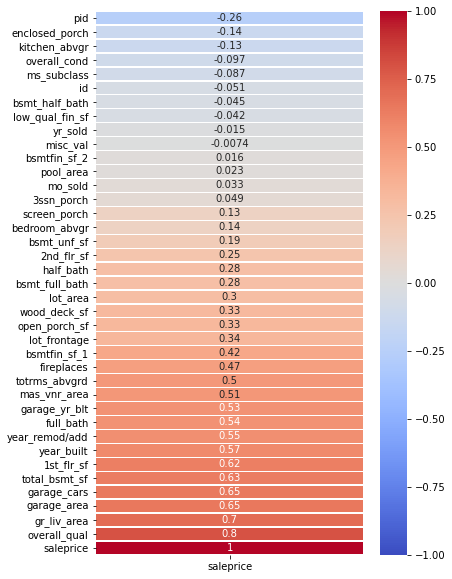

In [10]:
plt.figure(figsize = (6, 10))
sns.heatmap(newdf.corr()[['saleprice']].sort_values('saleprice'), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 0.3);

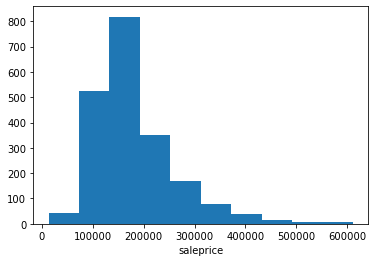

In [12]:
# examining features 
plt.hist(train['saleprice'])
plt.xlabel('saleprice');

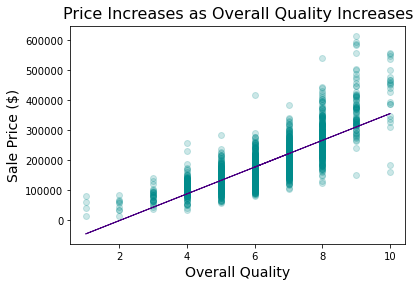

In [27]:
x = train['overall_qual']
y= train['saleprice']

plt.scatter(x, y, alpha = 0.2, color = 'darkcyan')

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, color = 'indigo', lw=1)

plt.xlabel('Overall Quality', size=14)
plt.ylabel('Sale Price ($)', size=14)
plt.title('Price Increases as Overall Quality Increases', pad=8, size=16);

The distribution has a strong positive skew. It may be a future consideration to make the target log(saleprice) but that is likely outside the scope of the time I have on this project.

In [12]:
train[train['total_bsmt_sf'].isnull()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1327,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,79000


In [13]:
train[train['garage_area'].isnull()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,150909


In [14]:
# going to drop the one row that has a null value in 'total_bsmt_sf'
# and 'garage_area'

train = train.dropna(subset=['total_bsmt_sf', 'garage_area'])

In [15]:
# turning 'central_air' into a dummy variable

train['central_air'] = train['central_air'].map({'Y': 1, 'N': 0})
test['central_air'] = test['central_air'].map({'Y': 1, 'N': 0})

In [16]:
# creating a column that adds together all the bathrooms

train['all_baths'] = train['full_bath'] + train['half_bath'] + train['bsmt_half_bath'] + train['bsmt_full_bath']

test['all_baths'] = test['full_bath'] + test['half_bath'] + test['bsmt_half_bath'] + test['bsmt_full_bath']


In [17]:
# examining huge lots - above 75th percentile or outliers?
# possible dummy column?

train.lot_area.describe()

count      2049.000000
mean      10067.712055
std        6745.127386
min        1300.000000
25%        7500.000000
50%        9434.000000
75%       11515.000000
max      159000.000000
Name: lot_area, dtype: float64

In [18]:
# examining price of all homes to compare (in below cell) to prices of houses with 
# huge lots 

train.saleprice.describe()

count      2049.000000
mean     181534.626159
std       79262.113026
min       12789.000000
25%      129850.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

In [19]:
# determining the cutoff for outliers and looking at stats for homes above the top outlier range

outlier_upper_la = np.quantile(train['lot_area'], 0.75) + (1.5 * (np.quantile(train['lot_area'], 0.75) - np.quantile(train['lot_area'], 0.25)))
outlier_upper_la
train[train['lot_area'] > outlier_upper_la]['saleprice'].describe()

count        84.000000
mean     229487.178571
std       99017.037385
min       57625.000000
25%      159375.000000
50%      215000.000000
75%      271242.500000
max      591587.000000
Name: saleprice, dtype: float64

In [20]:
train['huge_lot'] = [1 if value > outlier_upper_la else 0 for value in train['lot_area']]
test['huge_lot'] = [1 if value > outlier_upper_la else 0 for value in test['lot_area']]

### Considering US Recession

In [21]:
train.yr_sold.unique()

array([2010, 2009, 2006, 2007, 2008])

In [22]:
# consider that 2007-2009 was a huge recession....maybe account for that with variable?
train['recession'] = [1 if value in [2007, 2008] else 0 for value in train['yr_sold']]
test['recession'] = [1 if value in [2007, 2008] else 0 for value in test['yr_sold']]

### Accounting for Neighborhood

In the real estate world, we've all heard the saying "Location, location, location!" 

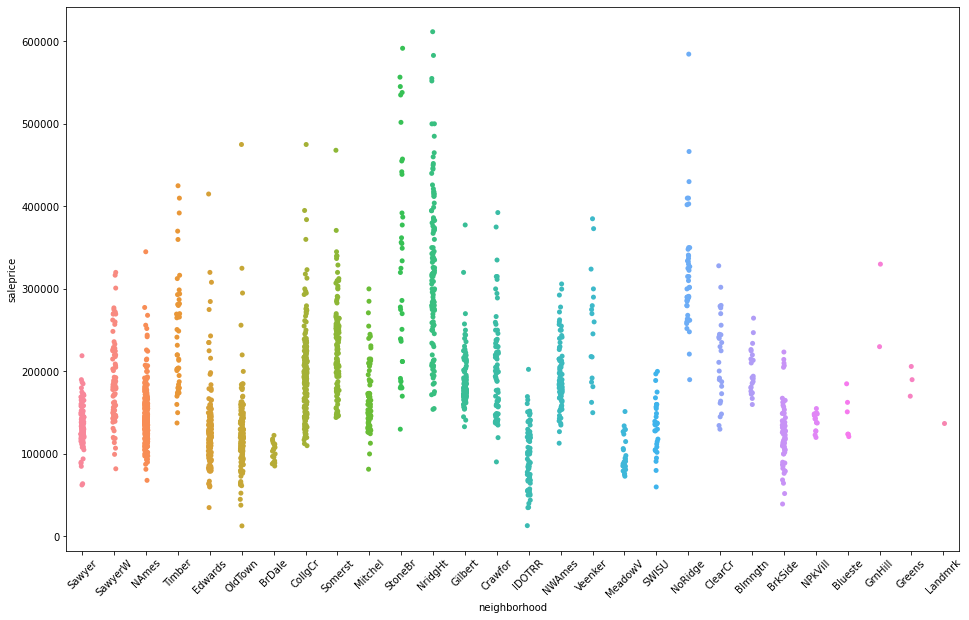

In [34]:
plt.figure(figsize = (16, 10))
sns.stripplot(x='neighborhood', y='saleprice', data=train, jitter=0.05)
plt.xticks(rotation=45);

In [23]:
# weighting the neighborhood - creating a new column with scaled mean
# got the idea from someone else's work on this data set
# who I connected with on LinkedIn https://github.com/scaress21/ames_housing
# mostly decided to do this after Riley reminded us through a different lesson 
# that generally people pull 'comps' on the 5 closest houses to you when 
# you're trying to appraise your home

neighborhood_scl = (train.groupby('neighborhood')['saleprice'].mean()) / 100000
neighborhood_scl

neighborhood
Blmngtn    2.004177
Blueste    1.445667
BrDale     1.033711
BrkSide    1.276630
ClearCr    2.174901
CollgCr    2.024972
Crawfor    2.059012
Edwards    1.304935
Gilbert    1.892284
Greens     1.886667
GrnHill    2.800000
IDOTRR     1.003707
Landmrk    1.370000
MeadowV    1.002312
Mitchel    1.676567
NAmes      1.459058
NPkVill    1.404765
NWAmes     1.946190
NoRidge    3.162941
NridgHt    3.228314
OldTown    1.252763
SWISU      1.347589
Sawyer     1.371819
SawyerW    1.877602
Somerst    2.271839
StoneBr    3.296757
Timber     2.410514
Veenker    2.535706
Name: saleprice, dtype: float64

In [24]:
neighborhoods = train['neighborhood'].unique().tolist()
neighborhoods.sort()

In [25]:
# dictionary comprehension to create a way to map a new column with what 
# I'm calling the neighborhood scalar
neighborhood_dict = {neighborhood: scalar for neighborhood, scalar in zip(neighborhoods, neighborhood_scl)}

In [26]:
train['neighborhood_scl'] = train['neighborhood'].apply(lambda x: neighborhood_dict[x])

In [27]:
test['neighborhood_scl'] = test['neighborhood'].apply(lambda x: neighborhood_dict[x])

### Attempting Polynomial Features

Once I plotted the heatmap, I wasn't thrilled with the correlation. The highest ones were more highly correlated on their own. I ended up commenting out most of the code but kept the imputed values to run initial models.

In [28]:
# before I impute anything, I want to save a copy of the data as is, so I can revert back to it if needed

train.to_csv('../datasets/train_clean1.csv', index=False)
test.to_csv('../datasets/test_clean1.csv', index=False)

In [29]:
# poly = PolynomialFeatures(include_bias = False)

In [30]:
# imputing values to look at polynomial features correlation

train['lot_frontage'].fillna(value=train['lot_frontage'].mean(), inplace=True)
train['garage_yr_blt'].fillna(value=train['garage_yr_blt'].mean(), inplace=True)
train['mas_vnr_area'].fillna(value=train['mas_vnr_area'].mean(), inplace=True)
train['bsmtfin_sf_1'].fillna(value=train['bsmtfin_sf_1'].mean(), inplace=True)
train['total_bsmt_sf'].fillna(value=train['total_bsmt_sf'].mean(), inplace=True)
train['bsmt_unf_sf'].fillna(value=train['bsmt_unf_sf'].mean(), inplace=True)
train['bsmtfin_sf_2'].fillna(value=train['bsmtfin_sf_2'].mean(), inplace=True)
train['all_baths'].fillna(value=train['all_baths'].mean(), inplace=True)

test['lot_frontage'].fillna(value=test['lot_frontage'].mean(), inplace=True)
test['garage_yr_blt'].fillna(value=test['garage_yr_blt'].mean(), inplace=True)
test['mas_vnr_area'].fillna(value=test['mas_vnr_area'].mean(), inplace=True)
test['bsmtfin_sf_1'].fillna(value=test['bsmtfin_sf_1'].mean(), inplace=True)
test['total_bsmt_sf'].fillna(value=test['total_bsmt_sf'].mean(), inplace=True)
test['bsmt_unf_sf'].fillna(value=test['bsmt_unf_sf'].mean(), inplace=True)
test['bsmtfin_sf_2'].fillna(value=test['bsmtfin_sf_2'].mean(), inplace=True)
test['all_baths'].fillna(value=test['all_baths'].mean(), inplace=True)


If I had more time, I would consider trying to look at each of these features individually and decide if it would be better to impute with the mean or the median (or in some other way - possibly with another feature with which it is correlated). If deciding between mean and median I would look to the skew of the feature. The more symmetric the data, the more I would lean toward choosing the mean. The more skewed, the more I would lean toward the median. 

In [31]:
# use numeric columns but append with dummies/engineered columns I have created
# newdf_columns_list = newdf.columns.to_list()

# list_to_add = ['huge_lot', 'all_baths', 'central_air']
# newdf_columns_list.extend(list_to_add)
# list_to_remove = ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'garage_cars',
#                     'enclosed_porch', '3ssn_porch']
# newdf_columns_list = [item for item in newdf_columns_list if item not in list_to_remove]


In [32]:
# poly.fit(train[newdf_columns_list])
# X_poly = poly.transform(train[newdf_columns_list])

In [33]:
# explore_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names())

In [34]:
# explore_poly['saleprice'] = train['saleprice']
# explore_poly.head()

In [35]:
# created an insanely huge heatmap that I didn't want to keep scrolling past. 
# ultimately the top correlations did not seem to be helpful

# plt.figure(figsize = (5, 200))
# sns.heatmap(explore_poly.corr()[['saleprice']].sort_values('saleprice'), 
#             annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 0.3)

Note to self that engineered features are: `'all_baths'`, `'central_air'`, `'huge_lot'`, and `'recession'`

### Features Iterations (First Attempt)

Chose best of 8 initial models.

In [36]:
features = ['gr_liv_area', 'garage_area', 'total_bsmt_sf', '1st_flr_sf', 'year_built', 
           'year_remod/add', 'full_bath', 'fireplaces', 'central_air', 
            'overall_qual', 'huge_lot', 'recession', 'mas_vnr_area', 'neighborhood_scl']


In [37]:
X = train[features]
y = train['saleprice']

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    random_state = 13, 
                                                    shuffle = True)

lr = LinearRegression()

lr.fit(X_train, y_train)

pred = lr.predict(X_val)

print(f'r^2 for train: {lr.score(X_train, y_train)}')
print(f'r^2 for val (test): {lr.score(X_val, y_val)}')
print(f'cross val score: {cross_val_score(lr, X_val, y_val).mean()}') 
print(f'rmse: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

r^2 for train: 0.840424905007071
r^2 for val (test): 0.7778938832844783
cross val score: 0.7239186892029869
rmse: 36993.1374822548


We can see from the scores that the model is drastically overfit and has high variance. 

## KFold Cross Validation

In [44]:
cv_results = cross_validate(lr, X, y, cv=KFold(shuffle=True, 
                                               random_state=13), 
                            scoring=['neg_root_mean_squared_error', 'r2'], 
                            n_jobs=-1, return_train_score=True, 
                            return_estimator=True)

results = pd.DataFrame(cv_results)
results.rename({'test_neg_root_mean_squared_error': 'test_rmse', 
                'train_neg_root_mean_squared_error': 'train_rmse'}, 
                axis=1, inplace=True)
results[['train_r2', 'test_r2', 
         'train_rmse', 'test_rmse']]
            

,train_r2,test_r2,train_rmse,test_rmse
0,0.841896,0.754504,-31643.237194,-38473.351984
1,0.816794,0.861999,-33483.588953,-30895.703918
2,0.833695,0.793082,-32602.571354,-34692.696171
3,0.827788,0.823438,-32489.990021,-34836.988121
4,0.822419,0.846795,-33765.667565,-29585.857492


In [38]:
residuals = y_val - pred

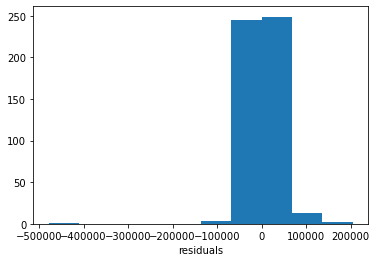

In [45]:
# exploring residuals

plt.hist(residuals)
plt.xlabel('residuals');

# negative skew
# trying to get more information on where my model is
# performing poorly (huge negative residual(s))

The majority of the data is centered around 0 (good!). However, the residuals have high variance (we don't want our sale price estimates to be off by $100,000.)

There are one or more super big negative residuals. We may want to explore that data at some point. If I had more time on this project, I would identify which values were the big negative residuals and consider if not including them in the dataset would improve my model. I may also simply for possible errors in that (or those) rows. 

Exporting CSV for kaggle submission:

In [40]:
X_test = test[features]

test['SalePrice'] = lr.predict(X_test)

export = test[['id', 'SalePrice']].copy()
export.rename(columns={'id':'Id'}, inplace=True)

# replace "REPLACE" with the attempt number to save as new csv in attempts folder
# export.to_csv('../attempts/attempt_REPLACE.csv', index = False)

## Exporting DataSets

In [41]:
# exporting current train and test datasets so I can begin 
# a new notebook, using my knowledge of Ridge and/or Lasso

train.to_csv('../datasets/train_imputed1.csv', index=False)
test.to_csv('../datasets/test_imputed1.csv', index=False)